# Stock market prediction using LSTM

## Importing stock

In [ ]:
# Need to pip install pandas_datareader and yfinance to your working conda environment
#!pip install pandas_datareader yfinance

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# For reading stock data from yahoo finance
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime

In [ ]:
import tensorflow.keras as keras

## Predict closing price of Microsoft

In [ ]:
stock = "MSFT"
start_date = '2018-01-01'
end_date = datetime.now()

In [ ]:
# Get the stock quote starting at certain date until current time
df = DataReader(stock, data_source='yahoo', start=start_date, end=end_date)

In [ ]:
df

In [ ]:
sns.pairplot(df)

In [ ]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)
ax1.plot(df['Close'],color='red',label="Closing price")
ax2 = ax1.twinx()
ax2.bar(df.index,df['Volume']/10**6,label="Volume")
ax2.grid(False)
plt.title("Daily Closing stock price and its volume of " + stock)
plt.xlabel("Date")
ax1.set_ylabel("Closing price (US$)")
ax2.set_ylabel("Volume (million)")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close' and 'Volume' 
df = df.filter(['Close','Volume'])


#### Setting up parameters

- Data was collected at daily interval.
- Using historical data of 30 days in the past: = **30 data points**
- To forecast stock the subsequent day = **1 data points**
- Data partition to **80% training** and **20% testing** in order of time
- For Neural Network, following parameters are pre-selected:
   - **Learning rate** = 0.001
   - **Batch size** = 24 (Batch size is the number of samples that usually pass through the neural network at one time)
   - **Epoch** = 50 (Epoch is the number of times that the entire dataset pass through the neural network)

In [ ]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))

step = 1 
past = 30

batch_size = 24
epochs = 50
learning_rate=0.001

As input data has different range, so there would be the need for **standardization**


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0,1))
scaled_features = pd.DataFrame(scale.fit_transform(df))
scaled_features.columns = df.columns
scaled_features.index = df.index

# The split of training and testing data must follow the sequential
train_data = scaled_features[0:train_split]
test_data =  scaled_features[train_split:]

train_data.head()

## Let's use only Closing price and Volume to predict the Closing price
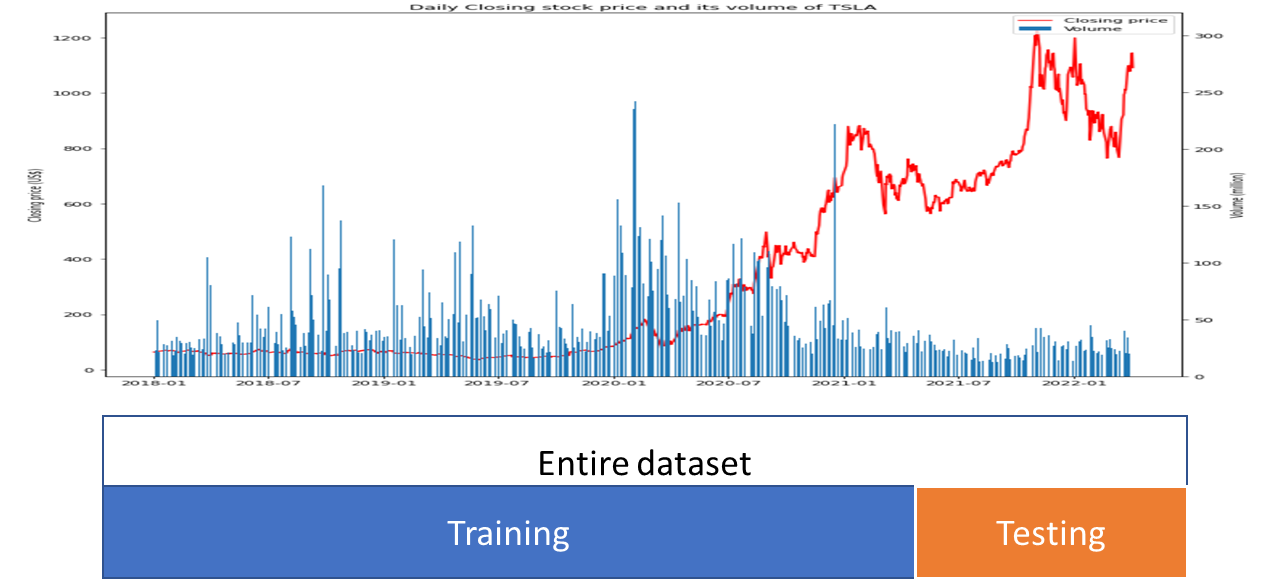

Detail explanation:


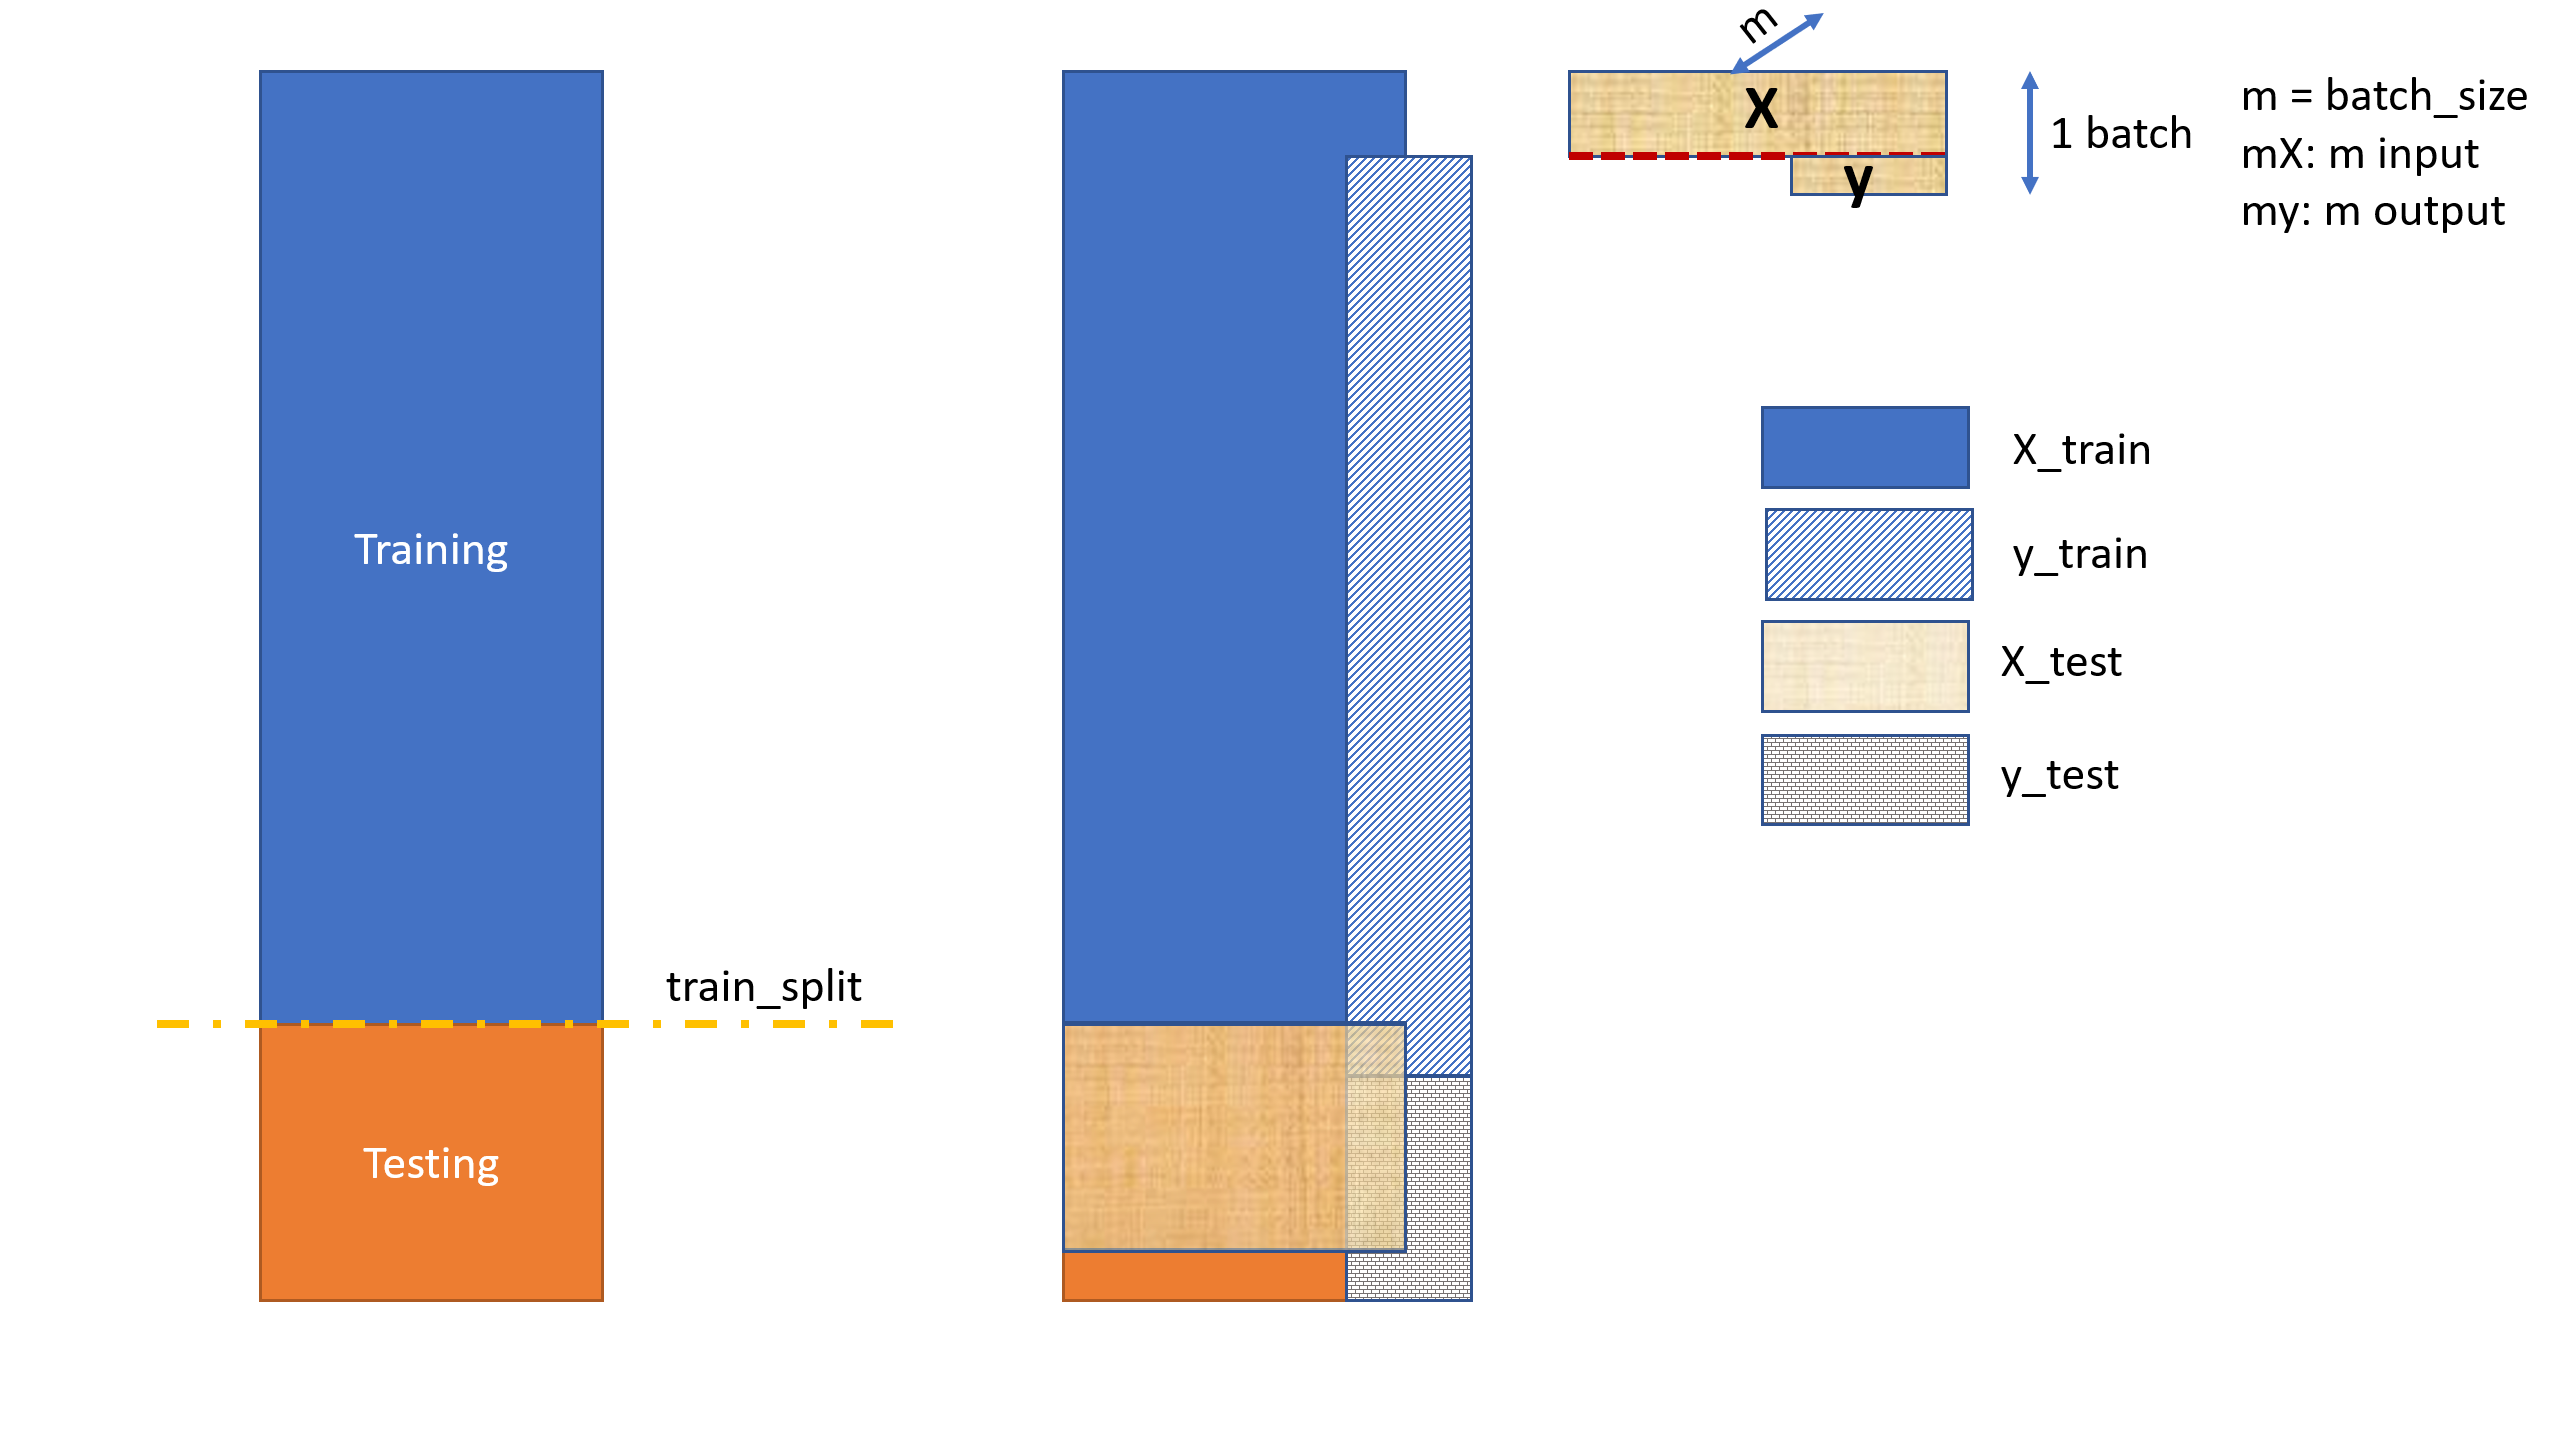

##### Training

In [ ]:
start_ytrain = past
end_ytrain = train_split + start_ytrain

x_train = train_data
y_train = scaled_features[start_ytrain:end_ytrain]["Close"]

sequence_length = int(past/step)

##### Testing

In [ ]:
start_ytest = end_ytrain
end_ytest = len(test_data) - past

x_test = test_data.iloc[:end_ytest,:]
y_test = scaled_features.iloc[start_ytest:]["Close"]


##### Validation

In [ ]:
valid_data = scaled_features.iloc[train_split - past: , :]
valid_data = np.array(valid_data)

x_valid = []
for i in range(past, len(valid_data)):
    x_valid.append(valid_data[i-past:i,:])

x_valid = np.array(x_valid)



#### Using Keras to split training/testing data to different batch:
Here, we utilize the preprocessing time series feature of keras to split training/testing data into different batch:

##### Training

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate = step,
    batch_size=batch_size,
)

In [ ]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

##### Testing

In [ ]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size
)

In [ ]:
for batch in dataset_test.take(1):
    inputs_test, targets_test = batch

print("Input shape:", inputs_test.numpy().shape)
print("Target shape:", targets_test.numpy().shape)

#### Build Deep learning model with LSTM framework:

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(64, activation="relu")(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

#### Train the LSTM model and validate with testing data set:


In [ ]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_test,
    verbose=2
)

#### Visualize the Training & Testing loss with 10 different epoches?


In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

#### Evaluate with Forecasting

In [ ]:
y_pred = model.predict(x_valid)

In [ ]:
#Create transformation function to rescale back to original
scaley = MinMaxScaler(feature_range=(0,1))
scaley.fit_transform(pd.DataFrame(df.iloc[:,0]))
y_pred = scaley.inverse_transform(y_pred)


In [ ]:
# Evaluate the output
from sklearn import metrics
print("R2 score is ",metrics.r2_score(df[train_split:]["Close"],y_pred))
print("RMSE is ", metrics.mean_squared_error(df[train_split:]["Close"],y_pred,squared=False)) # RMSE


In [ ]:
# Plot the data
train = df[:train_split]
valid = df[train_split:]
valid['Predictions'] = y_pred
# Visualize the data
plt.figure(figsize=(16,6))
plt.title(stock + ' price prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(0, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlabel("Time-Step")
    plt.ylabel("Closing cost US$()")
    plt.show()
    return

# Scale the data
scaleT = MinMaxScaler(feature_range=(0,1))
scaleT.fit_transform(pd.DataFrame(df[:]))

for x, y in dataset_test.take(8):
    show_plot(
        [scaley.inverse_transform(pd.DataFrame(x[0][:, 0])),
         scaley.inverse_transform(pd.DataFrame(pd.Series(y[0].numpy()))),
         scaley.inverse_transform(pd.DataFrame(model.predict(x)[0]))],         
        "Single Step Prediction",
    )

## Save model

In [ ]:
model.save('Stock_prediction_MSFT.keras')

## Load the save model and predict tomorrow closing price for stock

In [ ]:
model1 = keras.models.load_model('Stock_prediction_MSFT.keras')

In [ ]:
stock = "MSFT"
start_date = '2018-01-01'
end_date = datetime.now()
df = DataReader(stock, data_source='yahoo', start=start_date, end=end_date)

In [ ]:
# Retain the last 30 data for prediction
df = df.tail(30).filter(["Close","Volume"])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0,1))
X = pd.DataFrame(scale.fit_transform(df))

scaley= MinMaxScaler(feature_range=(0,1))
scaley.fit_transform(df[["Close"]])

In [ ]:
X = np.array(X).reshape(1,X.shape[0],X.shape[1])


In [ ]:
y=model.predict(X)
print("Predicted Closing price tomorrow for ", stock, "is", scaley.inverse_transform(pd.DataFrame(y)), "$")


In [ ]:
show_plot(
        [scaley.inverse_transform(pd.DataFrame(X[0])),
         scaley.inverse_transform(pd.DataFrame(y)),
         scaley.inverse_transform(pd.DataFrame(y))],         
        "Single Step Prediction")